# Notebook to compare results to gPhoton
Setup your source parameter and setting in the cell below.

In [1]:
region_name = "ALL_10-800" 
outdir = "./resources/gPhoton_out/"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"

srcs_ids = [4993 ,13580 ,14504 ,30475 ,50388 ,52994 ,79477 ,120265 ,138783 ,139480 ,162697 ,204419 ,221349 ,228958 ,236839 ,253214 ,253670
            ,256433 ,261213 ,331466 ,340464 ,381336 ,390864 ,489430 ,498065 ,525310 ,532554 ,533185 ,540235 ,583838 ,639720 ,645215 ,645730
            ,659787 ,666224 ,673175 ,680119 ,691408 ,714140 ,764827 ,1037284 ,1069077 ,1070938 ,1805505 ,1839206 ,2527679 ,3074917 ,] 
#srcs_ids = [4993]
srcs_ids = [193067 ,432606 ,535864 ,451644 ,1551422 ,541266 ,581995 ,625693 ,187856 ,8215 ,494782 ,166179 ,172775 ,34658 ,98746 ,
            1521738 ,2136829 ,297278 ,426363 ,426330 ,151796 ,305192 ,259271 ,388172 ,265150 ,54184 ,472623 ,419001 ,25273 ,26195 ,32448 ,199832 ,]# WD ALL_10-800

In [2]:
%matplotlib widget
import ipywidgets as widgets
import gPhoton
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table, join, vstack, MaskedColumn
from astropy import units as uu
import os
from vasca.utils import mag2flux, flux2mag, tgalex_to_astrotime
import vasca.visualization as vvis
from vasca.region import Region
from vasca.resource_manager import ResourceManager
import warnings
warnings.filterwarnings('ignore')

rg = Region()
rg.load_from_fits(region_fname)

#Subselect sources based on choice
if len(srcs_ids)>0:
    rg.tt_sources.add_index("rg_src_id")
    idx_srcs = rg.tt_sources.loc_indices["rg_src_id", srcs_ids]
    tt_srcs = Table(rg.tt_sources[idx_srcs])
else:
    tt_srcs = rg.tt_sources


#display(tt_srcs)

### Get gPhoton and VASCA light curve for each sources and show correlation

Nr of points all/matched: 2334 / 1205


time_gp,time_bin_size_gp,flux_gp,flux_err_gp,sel_gp,obs_filter_gp,obs_filter_id,flags,s2n,rg_src_id,rtime,time_src,time_bin_size_src,flux_src,flux_err_src,ul,sel_src,obs_filter_src,r_fov,artifacts,class_star,chkobj_type,size_world,ellip_world,flux_auto,flux_auto_err,vis_id,pull,pull_auto
d,s,1e-06 Jy,1e-06 Jy,,,,,,,,d,s,1e-06 Jy,1e-06 Jy,1e-06 Jy,,,deg,,,,arcsec,,Jy,Jy,,1e-06 Jy,1e-06 Jy
float64,float32,float32,float32,bool,bytes8,int32,int64,float32,int64,float64,float64,float32,float32,float32,float32,bool,bytes8,float32,int64,float32,int32,float32,float32,float32,float32,uint64,float32,float32
53916.29374415509,979.0,38.753586,5.194577,False,FUV,2,4,8.728303,193067,53916.29,53916.29372685195,976.0,80.08072,10.0863085,-1.0,True,FUV,0.33658302,0,0.983571,0,2.6583416,0.10032165,76.8698,9.494286,2553683925360705536,-4.0973496,-4.0146475
53916.503339062496,1703.0,39.595673,3.6151028,False,FUV,2,4,12.502364,193067,53916.5,53916.503339120696,1703.0,61.7839,5.8269005,-1.0,True,FUV,0.37498164,0,0.9837746,0,2.5610788,0.041374072,58.040627,5.420223,2553683925394259968,-3.8078957,-3.402988
52992.04042239583,141.0,27.13243,6.3510666,False,FUV,2,8,5.3178163,535864,52992.04,52992.040422453705,141.0,51.978,7.2964883,-1.0,True,FUV,0.38446996,0,0.983483,0,2.4237053,0.16841763,48.665028,6.7873874,2548793297908793344,-3.405141,-3.172443
53322.40333327546,1704.0,458.81302,5.770335,True,FUV,2,0,79.59253,451644,53322.4,53322.40329918972,1698.1,481.95096,6.1178255,-1.0,True,FUV,0.46571046,0,0.9973838,0,3.7154098,0.027291374,474.70914,5.724108,2552522841014665216,-3.7820528,-2.7770472
53322.88386568287,1502.0,452.2259,6.1823807,True,FUV,2,0,73.1325,451644,53322.88,53322.883688078735,1471.3,481.10693,6.553547,-1.0,True,FUV,0.45383736,0,0.98314375,0,3.7569664,0.033193007,467.04813,6.121213,2552522841081774080,-4.406933,-2.421454
53323.09124415509,1167.0,434.00427,6.9492188,True,FUV,2,0,62.81968,451644,53323.09,53323.09101591452,1127.55,468.9227,6.120143,-1.0,True,FUV,0.44225457,0,0.9998517,0,3.8000083,0.11979635,459.98517,5.71857,2552522841115328512,-5.705492,-4.54325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54962.5828240162,1298.0,522.948,7.057058,True,FUV,2,0,74.66881,26195,54962.58,54962.58281249983,1296.0,550.3718,8.115362,-1.0,True,FUV,0.25186342,0,0.9973301,0,3.3731067,0.09032493,537.62085,7.5652485,2597312546717302784,-3.3792489,-1.9395069


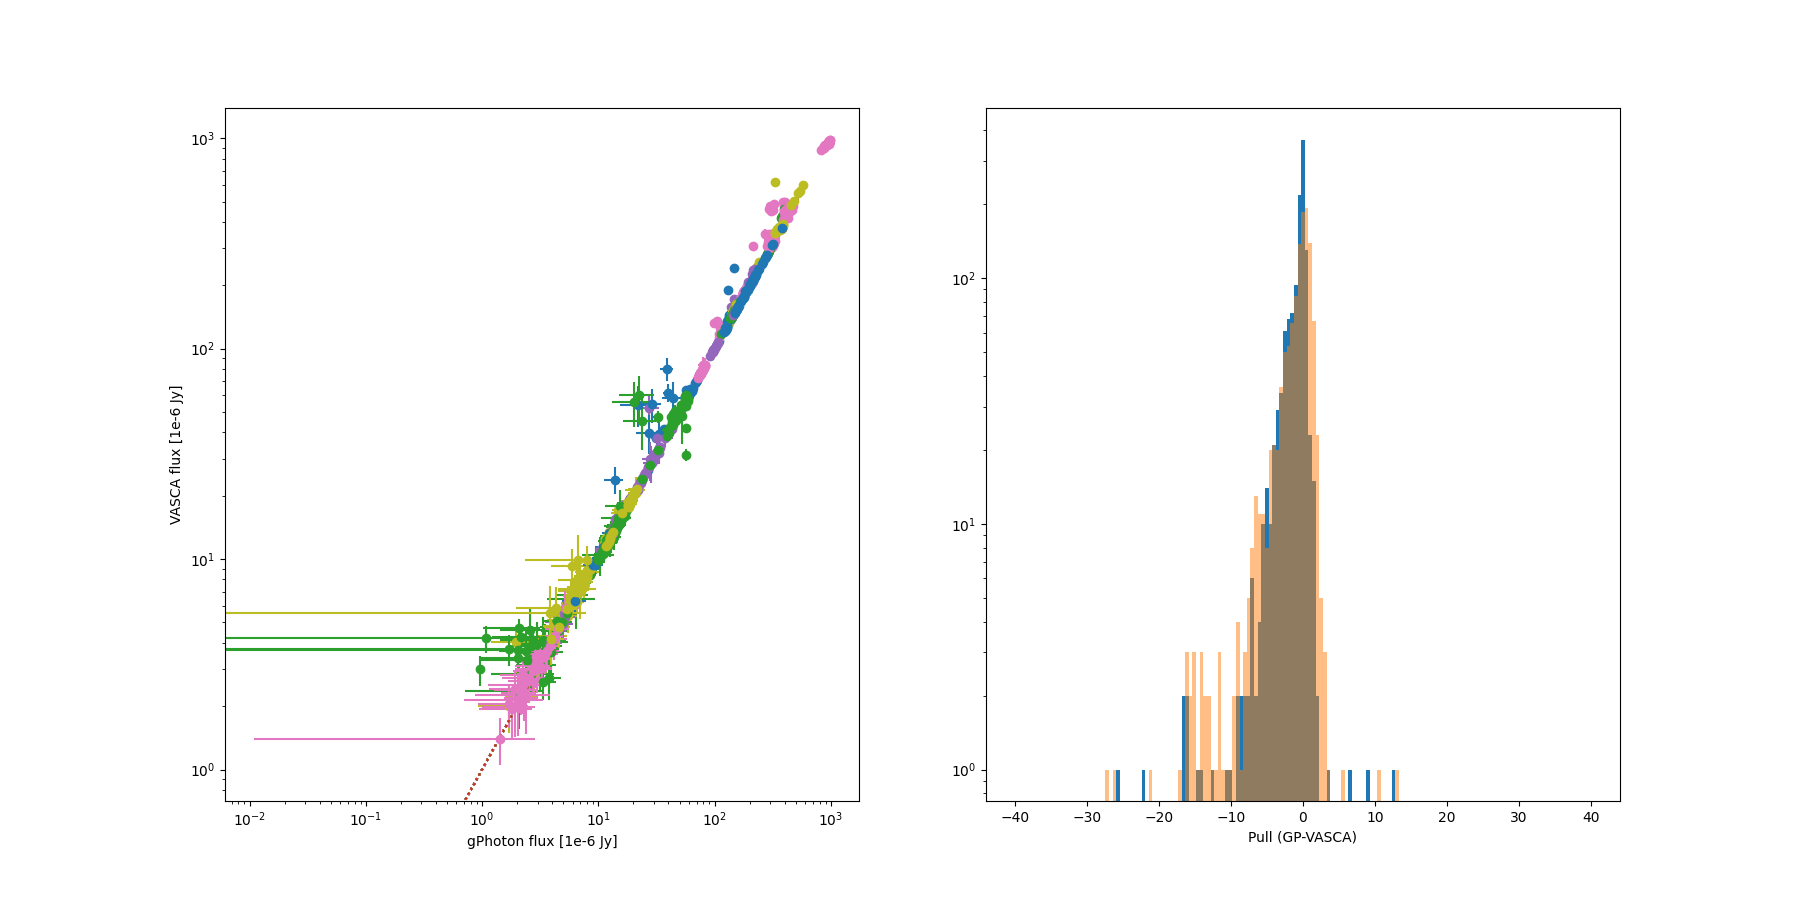

In [3]:
fig, axs = plt.subplots(1,2,figsize=(18, 9), squeeze=True, num="gPhotFlux", clear=True) 
axs = axs.flatten()
ll_lc = []
for rg_src_id in srcs_ids:

    #Get source
    tc_src = rg.get_src_from_id(rg_src_id, load_from_file = True, add_sed=False,add_gphoton=True, add_spectrum=False)

    if "tt_gphoton_lc" not in tc_src._table_names:
        print(f"Skipping src_id {rg_src_id}")
        continue
    
    tt_gp_lc = tc_src.tt_gphoton_lc
    tt_gp_lc["rg_src_id"] = rg_src_id
    tt_gp_lc["rtime"]=np.round(tt_gp_lc["time"],2)
    tt_src_lc = tc_src.tt_source_lc
    tt_src_lc["rtime"]=np.round(tt_src_lc["time"],2)
    tt_lc = join(tt_gp_lc,tt_src_lc,keys=['obs_filter_id',"rtime"],join_type='outer',table_names=["gp","src"])
    tt_lc["time_gp"] = MaskedColumn(tt_lc["time_gp"])
    tt_lc["time_src"]= MaskedColumn(tt_lc["time_src"])
    #display(tt_lc)
    sel_both = ~tt_lc["time_gp"].mask*~tt_lc["time_src"].mask
    tt_lc_both = tt_lc[sel_both]
    #sel_gp = tt_lc_both["sel_gp"]#*tt_lc_both["s2n"]>3

    ll_lc.append(tt_lc)
    #display(tt_lc[sel_both])
    
    #axs[0].plot(,"o")
    axs[0].errorbar(tt_lc_both["flux_gp"],tt_lc_both["flux_src"], xerr=tt_lc_both["flux_err_gp"], yerr=tt_lc_both["flux_err_src"],linestyle="none",marker="o")
    axs[0].set_xlabel("gPhoton flux [1e-6 Jy]")
    axs[0].set_ylabel("VASCA flux [1e-6 Jy]")
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].plot(range(600),range(600),":")
tt_lc = vstack(ll_lc)
sel_both = (~tt_lc["time_gp"].mask*~tt_lc["time_src"].mask)#*tt_lc["sel_gp"]
tt_lc_both = tt_lc[sel_both]
tt_lc_both["pull"] = (tt_lc_both["flux_gp"]-tt_lc_both["flux_src"])/tt_lc_both["flux_err_src"]
tt_lc_both["pull_auto"] = (tt_lc_both["flux_gp"]-tt_lc_both["flux_auto"])/tt_lc_both["flux_auto_err"]
axs[1].hist(tt_lc_both["pull"],bins=np.linspace(-40,40,160))
axs[1].hist(tt_lc_both["pull_auto"],bins=np.linspace(-40,40,160), alpha=0.5)
axs[1].set_yscale("log")
axs[1].set_xlabel("Pull (GP-VASCA)")
print("Nr of points all/matched:",len(tt_lc),"/",len(tt_lc_both))
display(tt_lc_both[np.abs(tt_lc_both["pull"])>3.])
#display(tt_lc_both[np.abs(tt_lc_both["pull"])>3.][12:])
#display(tt_lc)


#Add variables to visit information table and plot distributions for new variables

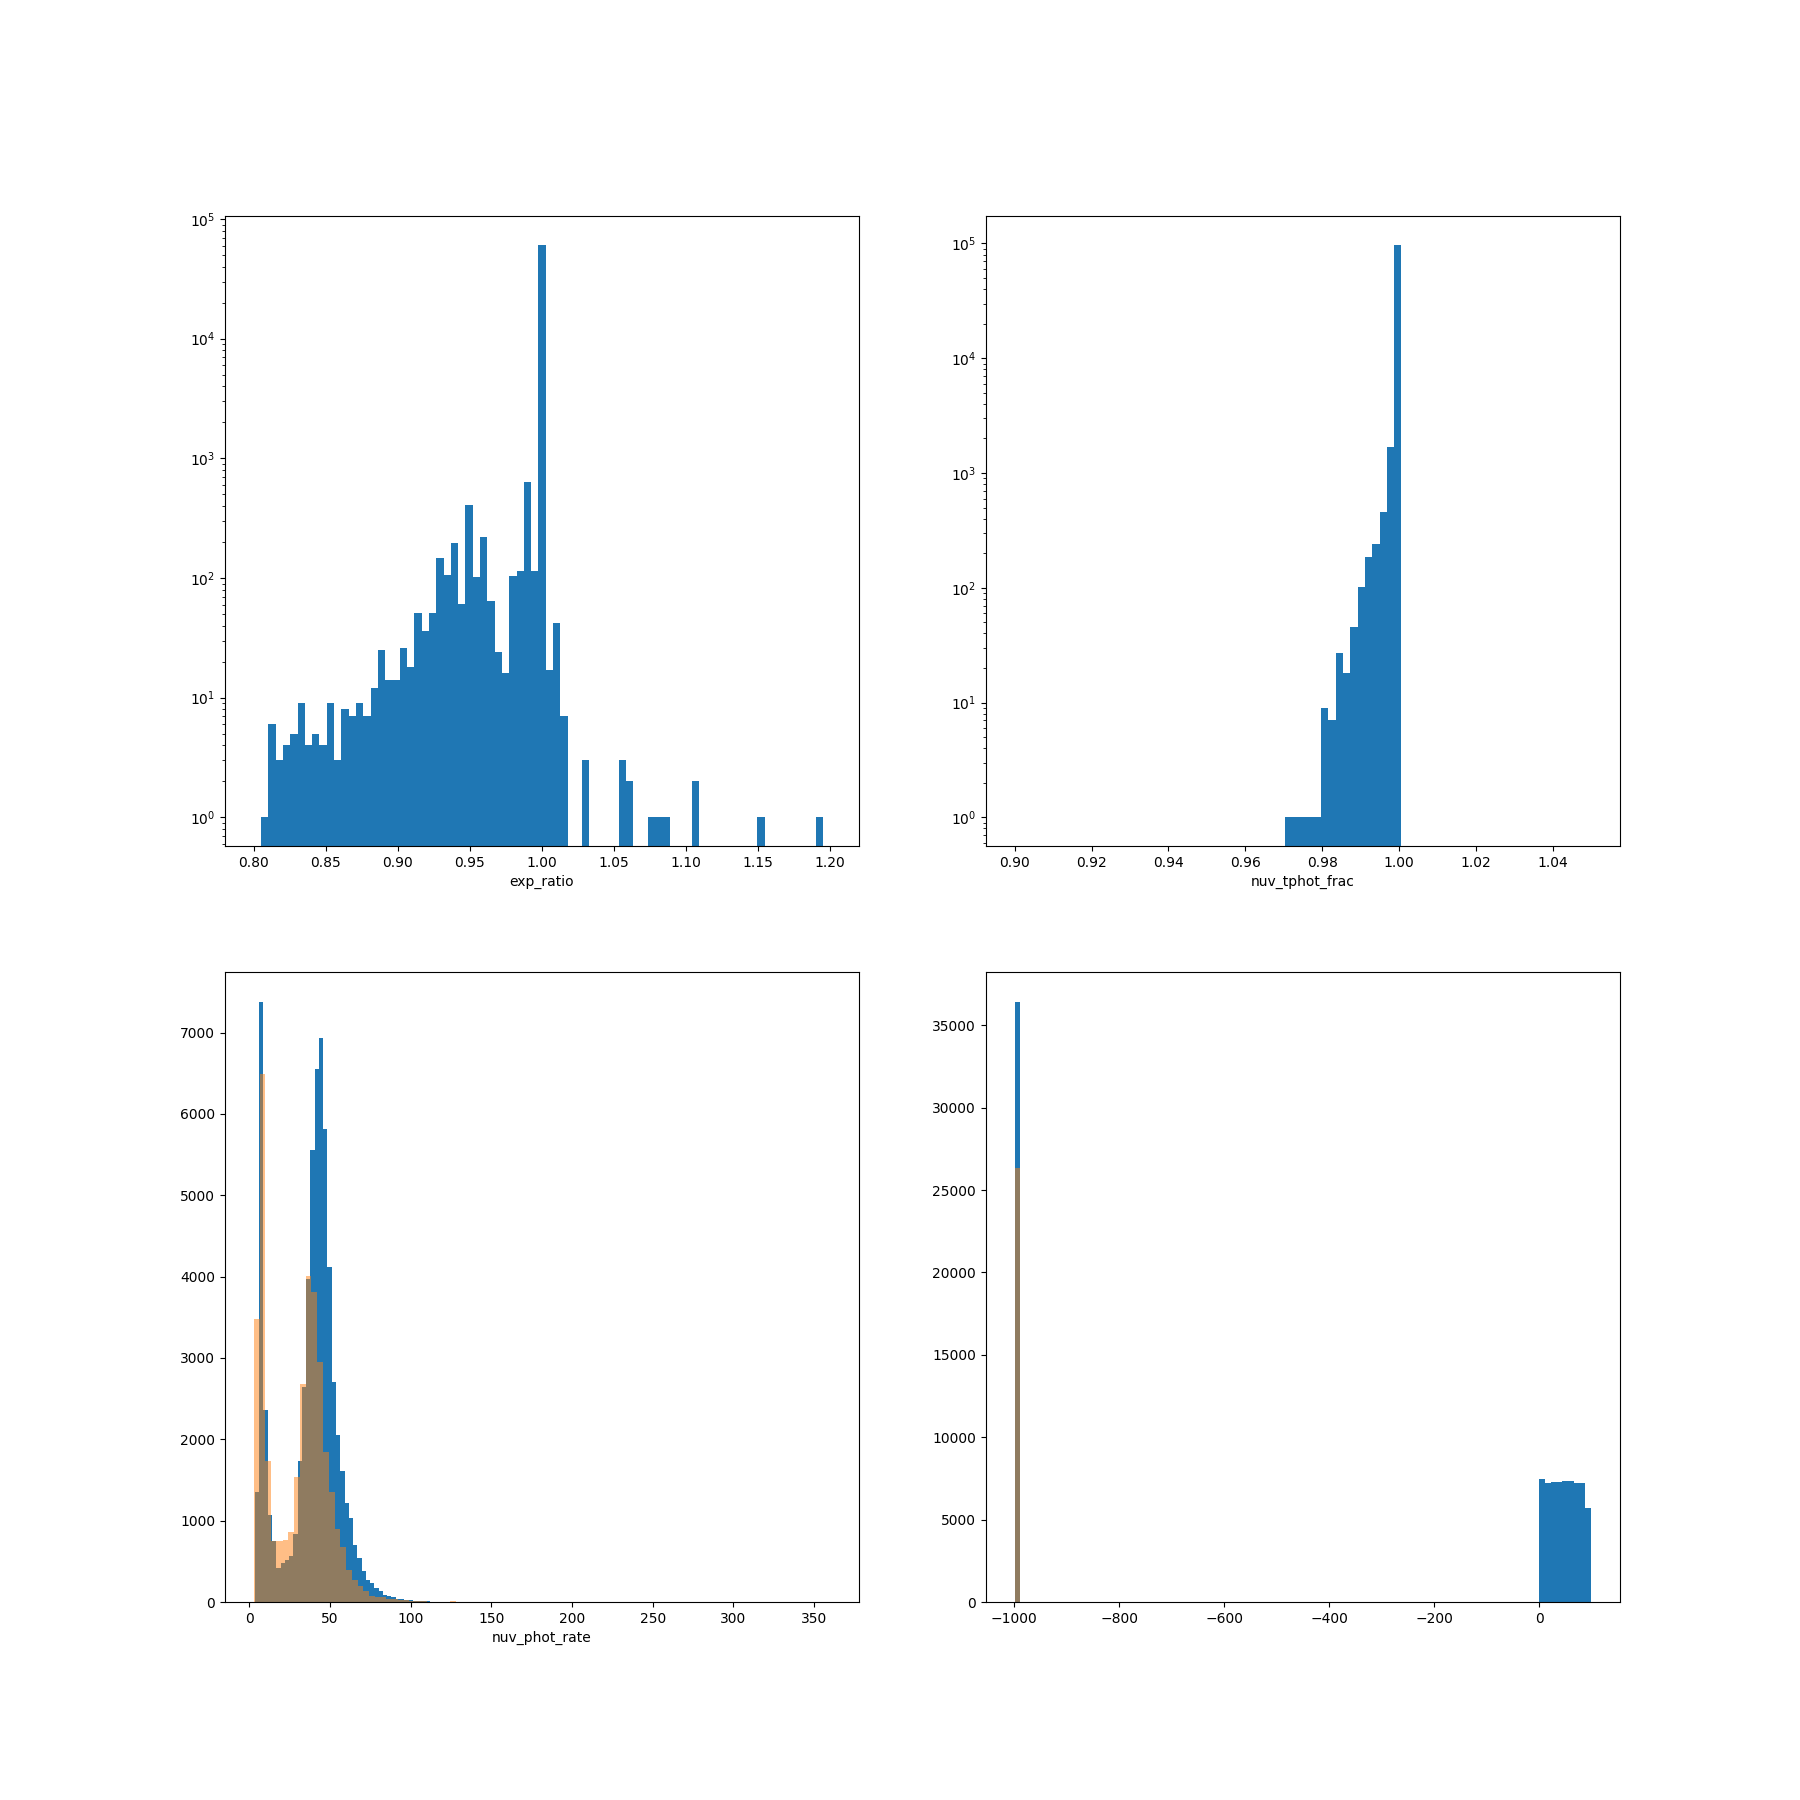

RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb,vis_id,exp_ratio,minPhotoObsDate_MJD,maxPhotoObsDate_MJD,delta_time_phot,nuv_tphot_frac,nuv_phot_rate
float64,float64,bytes3,float64,float64,int64,int64,int64,int64,int64,bytes6,int64,int64,bytes22,bytes5,bytes4,bytes4,bytes4,int64,int64,bytes22,bytes22,bytes4,bytes4,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
210.542232477159,-32.6804067553693,NGS,544.0,544.0,2391589523080347648,2391589660720627712,7804,2437,-999,visitI,7781,1,6/7/2003 5:02:29 AM,False,null,null,null,1,-999,6/7/2003 5:02:29 AM,6/7/2003 5:11:33 AM,null,null,52797.21005787037,319.74270865062874,27.871918173555255,2391589523080347648,1.0,52797.21005787037,52797.21635416667,544.0000001806766,1.000000000332126,14.303308823529411
201.528614022379,-42.9957260941383,NGS,937.0,937.0,2391624707452436480,2391624845092716544,74460,2438,-999,visitI,8258,1,6/7/2003 6:41:02 AM,False,null,null,null,1,-999,6/7/2003 6:41:02 AM,6/7/2003 6:56:39 AM,null,null,52797.278495370374,309.64494588030084,19.423571577159674,2391624707452436480,1.0,52797.278495370374,52797.28934027778,936.9999996386468,0.9999999996143509,8.813233724653148
203.769181415483,-30.085639855328,NGS,1349.05,1349.05,2391659891824525312,2391660029464805376,55314,2439,-999,visitI,10310,1,6/7/2003 8:19:41 AM,False,null,null,null,1,-999,6/7/2003 8:19:41 AM,6/7/2003 8:42:10 AM,null,null,52797.34700231482,314.0467834685246,31.84251982355922,2391659891824525312,1.0,52797.34700231482,52797.36261574074,1348.999999766238,0.9999629367082303,7.64241503280086
231.921642929177,3.34027063665351,MIS,1696.0,1696.0,2391730260568702976,2391730398208983040,60377,2441,-999,visitI,11931,1,6/7/2003 11:37:03 AM,False,null,null,null,1,-999,6/7/2003 11:37:03 AM,6/7/2003 12:05:19 PM,null,null,52797.4840625,7.318115437067729,45.76107027896758,2391730260568702976,1.0,52797.4840625,52797.50369212963,1695.9999997867271,0.9999999998742495,7.034787735849057
231.294710460205,2.47871950720032,MIS,1698.45,1698.45,2391765444940791808,2391765582581071872,80501,2442,-999,visitI,12210,1,6/7/2003 1:15:37 PM,False,null,null,null,1,-999,6/7/2003 1:15:37 PM,6/7/2003 1:43:55 PM,null,null,52797.552511574075,5.791997165545202,45.74212396120733,2391765444940791808,1.0,52797.552511574075,52797.572164351855,1698.000000254251,0.9997350526976072,7.188907533339221
230.830932461494,3.23716734012699,MIS,1700.05,1700.05,2391800629312880640,2391800766953160704,19263,2443,-999,visitI,12072,1,6/7/2003 2:54:16 PM,False,null,null,null,1,-999,6/7/2003 2:54:16 PM,6/7/2003 3:22:36 PM,null,null,52797.62101851852,6.256101183947215,46.57064854646065,2391800629312880640,1.0,52797.62101851852,52797.640694444446,1700.0000000931323,0.9999705891551027,7.100967618599453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56.7904848964983,39.267724266169,MIS,1470.15,0.0,4576116817365303296,4576116954972028928,11983,64525,-999,visitI,6180,1,12/29/2010 9:02:14 PM,False,null,null,null,2,-999,12/29/2010 9:02:14 PM,12/29/2010 9:26:44 PM,null,null,55559.876550925925,156.23686517319442,-11.982164915190525,4576116817365303296,0.0,55559.876550925925,55559.89356481482,1470.0000003911555,0.9998979698610042,4.203652688501173
57.0123625434868,17.1333305517839,MIS,1614.2,0.0,4576363107911204864,4576363245576650752,64109,64532,-999,visitI,5365,1,12/22/2011 8:09:11 PM,False,null,null,null,1,-999,12/22/2011 8:09:11 PM,12/22/2011 8:36:05 PM,null,null,55917.83971064815,172.11985424568047,-28.41685586315213,4576363107911204864,0.0,55917.83971064815,55917.85839120371,1614.0000001061708,0.9998760996816818,3.32362780324619


Total Nr of visits with NUV exposure / selected 100509 / 74031


In [4]:
from datetime import datetime
from astropy.time import Time

#Read visit  table
tt_vis = Table.read("/home/buehler/Data/galex/GALEX_visits_list/GALEX_visits_list.fits")
tt_vis = tt_vis[tt_vis["nexptime"]>1]
tt_vis['vis_id'] = tt_vis['imgRunID']


#Add variables
tt_vis["exp_ratio"] = tt_vis["fexptime"]/tt_vis["nexptime"]

# Add times
ll_tmin = [
    datetime.strptime(date_str.decode("utf-8"), "%m/%d/%Y %I:%M:%S %p")
    for date_str in tt_vis["minPhotoObsDate"].data
]
tt_vis["minPhotoObsDate_MJD"] = Time(ll_tmin).mjd

ll_tmax = [
    datetime.strptime(date_str.decode("utf-8"), "%m/%d/%Y %I:%M:%S %p")
    for date_str in tt_vis["maxPhotoObsDate"].data
]
tt_vis["maxPhotoObsDate_MJD"] = Time(ll_tmax).mjd

tt_vis["delta_time_phot"] = (tt_vis["maxPhotoObsDate_MJD"]-tt_vis["minPhotoObsDate_MJD"])*24*60*60
tt_vis["nuv_tphot_frac"] = tt_vis["delta_time_phot"]/ tt_vis["nexptime"]

tt_vis["nuv_phot_rate"] = tt_vis["nPhotoObjects"]/tt_vis["nexptime"]

figv, axsv = plt.subplots(2,2,figsize=(18,18), squeeze=True, num="visit", clear=True) 
axsv = axsv.flatten()

axsv[0].hist(tt_vis["exp_ratio"],bins=np.linspace(0.8,1.2,80))
axsv[0].set_xlabel("exp_ratio")
axsv[0].set_yscale("log")

axsv[1].hist(tt_vis["nuv_tphot_frac"],bins=np.linspace(0.9,1.05,80))
axsv[1].set_xlabel("nuv_tphot_frac")
axsv[1].set_yscale("log")

axsv[2].hist(tt_vis["nuv_phot_rate"][tt_vis["fexptime"]>1],bins=100)
axsv[2].hist(tt_vis["nuv_phot_rate"][tt_vis["fexptime"]<1],bins=100, alpha=0.5)
axsv[2].set_xlabel("nuv_phot_rate")
#axsv[2].set_yscale("log")

axsv[3].hist(tt_vis["subvis"],bins=100)
axsv[3].hist(tt_vis["subvis"][tt_vis["nuv_phot_rate"] <20],bins=100, alpha=0.5)
#axsv[3].set_xlabel("nuv_tphot_frac")

plt.show()

display(tt_vis[tt_vis["nuv_phot_rate"]<20])

sel_exp_ratio = (tt_vis["exp_ratio"] >0.99) * ((tt_vis["exp_ratio"] <1.01))
sel_nuv_phot_rate = tt_vis["nuv_phot_rate"]>20
sel_vis =sel_nuv_phot_rate #  sel_exp_ratio*
print("Total Nr of visits with NUV exposure / selected",len(tt_vis),"/",sel_vis.sum())
tt_vis.write("/home/buehler/Data/galex/GALEX_visits_list/GALEX_visits_list_qualsel_tmp.fits", overwrite=True)

### Join lichtcurve point summary table with visit  table and plot distributions o

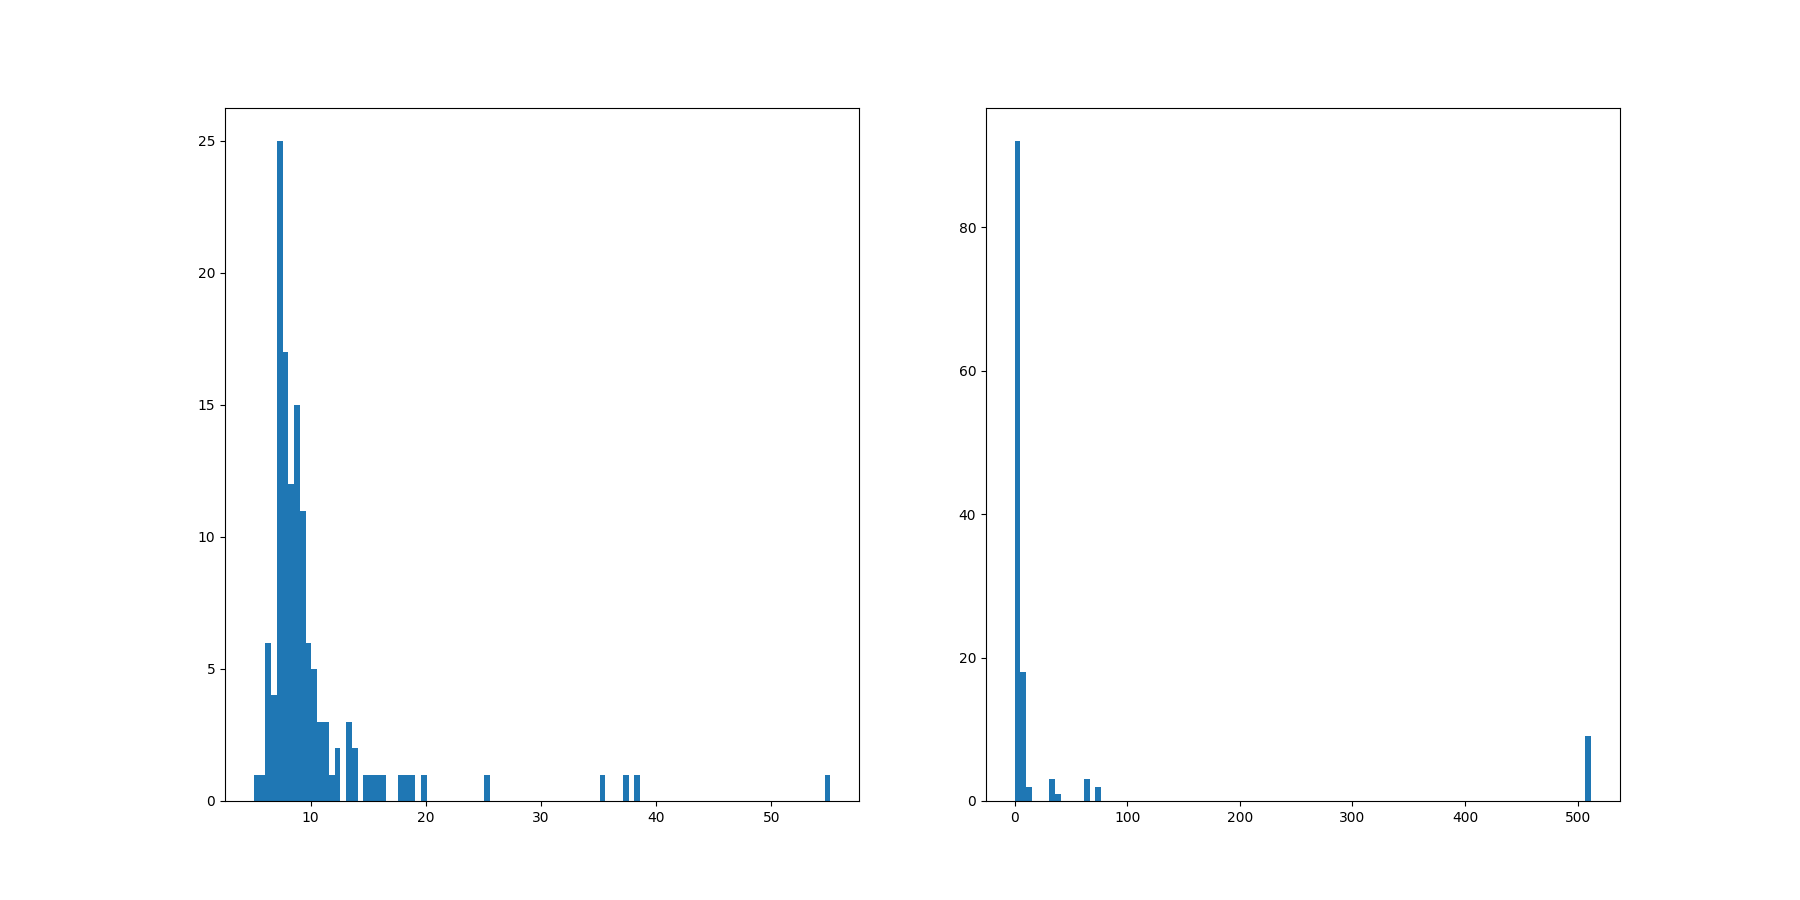

time_gp,time_bin_size_gp,flux_gp,flux_err_gp,sel_gp,obs_filter_gp,obs_filter_id,flags,s2n,rg_src_id,rtime,time_src,time_bin_size_src,flux_src,flux_err_src,ul,sel_src,obs_filter_src,r_fov,artifacts,class_star,chkobj_type,size_world,ellip_world,flux_auto,flux_auto_err,vis_id,pull,pull_auto,RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb,exp_ratio,minPhotoObsDate_MJD,maxPhotoObsDate_MJD,delta_time_phot,nuv_tphot_frac,nuv_phot_rate
d,s,1e-06 Jy,1e-06 Jy,,,,,,,,d,s,1e-06 Jy,1e-06 Jy,1e-06 Jy,,,deg,,,,arcsec,,Jy,Jy,,1e-06 Jy,1e-06 Jy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
float64,float32,float32,float32,bool,bytes8,int32,int64,float32,int64,float64,float64,float32,float32,float32,float32,bool,bytes8,float32,int64,float32,int32,float32,float32,float32,float32,float64,float32,float32,float64,float64,bytes3,float64,float64,int64,int64,int64,int64,int64,bytes6,int64,int64,bytes22,bytes5,bytes4,bytes4,bytes4,int64,int64,bytes22,bytes22,bytes4,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64
54866.31244207176,1256.0,193.44128,5.1165514,False,FUV,2,40,38.860107,419001,54866.31,54866.30991695615,1043.65,208.2652,4.1125374,-1.0,True,FUV,0.4969766,0,0.9859769,0,2.9962587,0.15122719,200.7179,3.8175704,2.5021740045555466e+18,-3.6045663,-1.9060844,140.52479129691,50.9805437163572,NGS,1043.65,1043.65,2502174004555546624,2502174141994500096,59800,5580,-999,visitI,10590,1,2/4/2009 7:17:35 AM,False,null,null,null,1,-999,2/4/2009 7:17:35 AM,2/4/2009 7:34:58 AM,null,null,54866.303877314815,166.9342366510842,44.159038805756104,1.0,54866.303877314815,54866.31594907407,1042.9999999003485,0.9993771857426804,10.147079959756622
54867.33937494213,1448.0,222.22511,5.1458488,False,FUV,2,32,43.843918,419001,54867.34,54867.33715567127,1102.5,238.23206,3.8337295,-1.0,True,FUV,0.49766877,0,0.9953132,0,3.2068095,0.054404333,228.29533,3.5539067,2.5021740046226555e+18,-4.1752925,-1.7080418,140.519801043312,50.9833565445376,NGS,1102.5,1102.5,2502174004622655488,2502174141994500096,98462,5580,-999,visitI,10511,1,2/5/2009 7:56:19 AM,False,null,null,null,3,-999,2/5/2009 7:56:19 AM,2/5/2009 8:14:41 AM,null,null,54867.330775462964,166.93121307693252,44.155422624563194,1.0,54867.330775462964,54867.34353009259,1101.9999998621643,0.9995464851357498,9.533786848072562
54869.050925868054,1512.0,208.41902,4.8425593,False,FUV,2,32,43.669586,419001,54869.05,54869.04866030079,1150.5,225.61261,3.3853626,-1.0,True,FUV,0.4989795,0,0.983647,0,3.1509354,0.081250794,218.81412,3.145179,2.5021740047904276e+18,-5.0788026,-3.3050888,140.517687797407,50.9828481797626,NGS,1150.5,1150.5,2502174004790427648,2502174141994500096,77625,5580,-999,visitI,10567,1,2/7/2009 1:00:29 AM,False,null,null,null,8,-999,2/7/2009 1:00:29 AM,2/7/2009 1:19:39 AM,null,null,54869.04200231482,166.93225887434977,44.15421208613781,1.0,54869.04200231482,54869.0553125,1149.9999997671694,0.999565406142694,9.184702303346372
54870.21133096065,894.0,215.25645,6.5775537,False,FUV,2,32,33.523983,419001,54870.21,54870.20999016186,662.3,237.07133,5.869836,-1.0,True,FUV,0.48178437,0,0.9943992,0,2.9871473,0.086510465,229.56293,5.4610763,2.502174004823982e+18,-3.7164378,-2.6197166,140.523132154239,51.0085480103287,NGS,662.3,662.3,2502174004823982080,2502174141994500096,51776,5580,-999,visitI,8665,1,2/8/2009 4:56:52 AM,False,null,null,null,9,-999,2/8/2009 4:56:52 AM,2/8/2009 5:07:54 AM,null,null,54870.20615740741,166.8961819908231,44.152720559607324,1.0,54870.20615740741,54870.21381944444,661.9999994756654,0.9995470322748987,13.083194926770346
54808.25023142361,1698.0,317.22733,5.3225164,True,FUV,2,0,60.368507,426363,54808.25,54808.25009432865,1674.3,332.79486,4.9296546,-1.0,True,FUV,0.3341774,0,0.9912646,0,2.8808784,0.05672731,313.95905,4.765683,2.509421985474281

In [5]:
tt_lc_vis = join(tt_lc_both,tt_vis,keys=['vis_id'],join_type='inner')
sel_pull = np.abs(tt_lc_vis["pull"])>3.  #Select LC points wth sig

figvl, axsvl = plt.subplots(1,2,figsize=(18,9), squeeze=True, num="visitlc", clear=True) 
axsvl = axsvl.flatten()

axsvl[0].hist(tt_lc_vis["nuv_phot_rate"][sel_pull],bins=100)
axsvl[1].hist(tt_lc_vis["flags"][sel_pull],bins=100)
plt.show()

display(tt_lc_vis[sel_pull])#[tt_lc_vis["nuv_phot_rate"][sel_pull]>25][:10]
#display(tt_lc_vis[sel_pull][tt_lc_vis["nuv_phot_rate"][sel_pull]>25][10:])